In [13]:
from tdc.multi_pred import DTI
import numpy as np
from get_dataloaders import get_dataloaders
from SimpleDTA import SimpleDTA
import torch
from matplotlib import pyplot as plt 
from sklearn.metrics import r2_score
import time 
import pandas as pd
from tdc.utils import uniprot2seq

In [14]:
-np.log10(1000e-9)

6.0

In [15]:
data = DTI(name = 'BindingDB_IC50', path='../data/')
data.convert_to_log(form = 'binding')
ic50 = data.harmonize_affinities('max_affinity')

Found local copy...
Loading...
Done!
To log space...


In [16]:
mytargets = pd.read_csv('../extdata/mytargets.csv')
mytargets.head()

,gene_symbol,gene_id,ensembl_id,uniprot_id,Gene Names,gene_title,gene_type,Reviewed,Entry Name,Organism,Length,Sequence
0,ABL2,27,ENSG00000143322,P42684,ABL2 ABLL ARG,"ABL proto-oncogene 2, non-receptor tyrosine ki...",protein-coding,reviewed,ABL2_HUMAN,Homo sapiens (Human),1182,MGQQVGRVGEAPGLQQPQPRGIRGSSAARPSGRRRDPAGRTTETGF...
1,ACVR2B,93,ENSG00000114739,Q13705,ACVR2B,activin A receptor type 2B,protein-coding,reviewed,AVR2B_HUMAN,Homo sapiens (Human),512,MTAPWVALALLWGSLCAGSGRGEAETRECIYYNANWELERTNQSGL...
2,ADCYAP1,116,ENSG00000141433,P18509,ADCYAP1,adenylate cyclase activating polypeptide 1,protein-coding,reviewed,PACA_HUMAN,Homo sapiens (Human),176,MTMCSGARLALLVYGIIMHSSVYSSPAAAGLRFPGIRPEEEAYGED...
3,ADCYAP1R1,117,ENSG00000078549,E9PFU5,ADCYAP1R1,ADCYAP receptor type I,protein-coding,unreviewed,E9PFU5_HUMAN,Homo sapiens (Human),524,MAGVVHVSLAALLLLPMAPAMHSDCIFKKEQAMCLEKIQRANELMG...
4,ADCYAP1R1,117,ENSG00000078549,C9JVH3,ADCYAP1R1,ADCYAP receptor type I,protein-coding,unreviewed,C9JVH3_HUMAN,Homo sapiens (Human),74,MAGVVHVSLAALLLLPMAPAMHSDCIFKKEQAMCLEKIQRANELMG...


In [17]:
mydrugs = pd.read_csv('../extdata/mydrugs.csv')
mydrugs.head()

,pert_id,cmap_name,canonical_smiles,smiles_len
0,BRD-K43002773,GDC-0068,C[C@@H]1C[C@H](C2=C1C(=NC=N2)N3CCN(CC3)C(=O)[C...,75
1,BRD-A50998626,palomid-529,COc1ccc(COc2cc3oc(=O)c4cc(ccc4c3cc2OC)C(C)O)cc1,47
2,BRD-K70301465,ibrutinib,Nc1ncnc2n(nc(-c3ccc(Oc4ccccc4)cc3)c12)[C@@H]1C...,61
3,BRD-K68407802,KIN001-055,COc1cc2ncnc(Nc3cc(Br)c(O)c(Br)c3)c2cc1OC,40
4,BRD-K42828737,sunitinib,CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2/C(=O)Nc3ccc(F)...,54


In [18]:
split = mytargets[['gene_symbol','uniprot_id', 'Sequence']].merge(mydrugs[['pert_id', 'canonical_smiles']], how='cross')
split = split.rename({'Sequence':'Target', 'canonical_smiles': 'Drug'}, axis=1)
print(len(split))
split.head()

5834980


,gene_symbol,uniprot_id,Target,pert_id,Drug
0,ABL2,P42684,MGQQVGRVGEAPGLQQPQPRGIRGSSAARPSGRRRDPAGRTTETGF...,BRD-K43002773,C[C@@H]1C[C@H](C2=C1C(=NC=N2)N3CCN(CC3)C(=O)[C...
1,ABL2,P42684,MGQQVGRVGEAPGLQQPQPRGIRGSSAARPSGRRRDPAGRTTETGF...,BRD-A50998626,COc1ccc(COc2cc3oc(=O)c4cc(ccc4c3cc2OC)C(C)O)cc1
2,ABL2,P42684,MGQQVGRVGEAPGLQQPQPRGIRGSSAARPSGRRRDPAGRTTETGF...,BRD-K70301465,Nc1ncnc2n(nc(-c3ccc(Oc4ccccc4)cc3)c12)[C@@H]1C...
3,ABL2,P42684,MGQQVGRVGEAPGLQQPQPRGIRGSSAARPSGRRRDPAGRTTETGF...,BRD-K68407802,COc1cc2ncnc(Nc3cc(Br)c(O)c(Br)c3)c2cc1OC
4,ABL2,P42684,MGQQVGRVGEAPGLQQPQPRGIRGSSAARPSGRRRDPAGRTTETGF...,BRD-K42828737,CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2/C(=O)Nc3ccc(F)...


In [19]:
# how many of the proteins in BindingDB_IC50 are in our gene-space? 

train_geneset_overlap = set(ic50.Target_ID.values).intersection(set(mytargets.uniprot_id.values))
len(train_geneset_overlap)


676

In [20]:
# how many of the drugs in BindingDB_IC50 are in our drug-space? 

train_drugset_overlap = set(ic50.Drug.values).intersection(mydrugs.canonical_smiles.values)
len(train_drugset_overlap)

76

In [25]:
data = DTI(name = 'BindingDB_Kd', path='../data/')
data.convert_to_log(form = 'binding')
kd = data.harmonize_affinities('max_affinity')
kd.head()

Found local copy...
Loading...
Done!
To log space...


,Drug_ID,Drug,Target_ID,Target,Y
0,51.0,O=C(O)CCC(=O)C(=O)O,Q9GZT9,MANDSGGPGGPSPSERDRQYCELCGKMENLLRCSRCRSSFYCCKEH...,5.657558
1,187.0,CC(=O)OCC[N+](C)(C)C,P11229,MNTSAPPAVSPNITVLAPGKGPWQVAFIGITTGLLSLATVTGNLLV...,4.759998
2,187.0,CC(=O)OCC[N+](C)(C)C,P58154,MRRNIFCLACLWIVQACLSLDRADILYNIRQTSRPDVIPTQRDRPV...,5.414528
3,237.0,CCN(CC)CCCC(C)Nc1c2ccc(Cl)cc2nc2ccc(OC)cc12,P02752,MLRFAITLFAVITSSTCQQYGCLEGDTHKANPSPEPNMHECTLYSE...,6.578232
4,242.0,O=C([O-])c1ccccc1,P14920,MRVVVIGAGVIGLSTALCIHERYHSVLQPLDIKVYADRFTPLTTTD...,5.045753


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


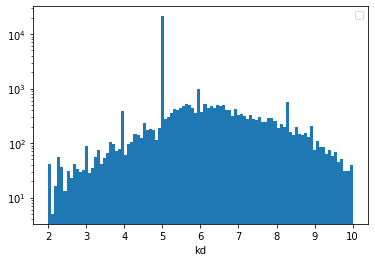

In [26]:
plt.figure()
plt.hist(kd.Y, bins=100)
plt.yscale('log')
plt.xlabel('kd')
plt.legend()
plt.show()

In [22]:
kd = kd.rename({'Y':'pkd'}, axis=1)
ic50 = ic50.rename({'Y':'pic50'}, axis=1)
res = kd.merge(ic50, on=['Drug', 'Target'])
res.head()

,Drug_ID_x,Drug,Target_ID_x,Target,pkd,Drug_ID_y,Target_ID_y,pic50
0,242.0,O=C([O-])c1ccccc1,P14920,MRVVVIGAGVIGLSTALCIHERYHSVLQPLDIKVYADRFTPLTTTD...,5.045753,242.0,P14920,4.182434
1,572.0,O=CN(O)CCCP(=O)(O)O,P9WNS1,MTNSTDGRADGRLRVVVLGSTGSIGTQALQVIADNPDRFEVVGLAA...,7.396856,572.0,P9WNS1,6.356449
2,985.0,CCCCCCCCCCCCCCCC(=O)O,P15090,MCDAFVGTWKLVSSENFDDYMKEVGVGFATRKVAGMAKPNMIISVN...,4.080921,985.0,P15090,6.031470
3,985.0,CCCCCCCCCCCCCCCC(=O)O,Q01469,MATVQQLEGRWRLVDSKGFDEYMKELGVGIALRKMGAMAKPDCIIT...,6.095771,985.0,Q01469,5.920783
4,1049.0,c1ccncc1,P08684,MALIPDLAMETWLLLAVSLVLLYLYGTHSHGLFKKLGIPGPTPLPF...,2.346787,1049.0,P08684,2.397940


6.114582234889064


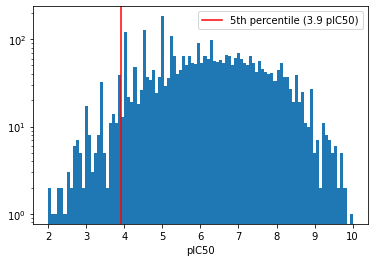

In [23]:
print(np.quantile(res.pic50, 0.5))

plt.figure()
plt.hist(res.pic50, bins=100)
plt.yscale('log')
plt.xlabel('pIC50')
plt.axvline(np.quantile(res.pic50, 0.05), c='r', label=f'5th percentile ({np.quantile(res.pic50, 0.05):.1f} pIC50)')
plt.legend()
plt.show()

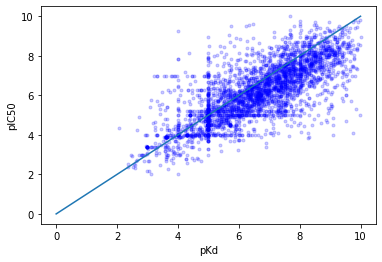

In [20]:
plt.figure()
plt.plot(res.pkd, res.pic50, 'b.', alpha=0.2)
plt.plot((0,10), (0,10))
plt.xlabel('pKd')
plt.ylabel('pIC50')
plt.show()

In [21]:
r2_score(res.pkd, res.pic50)

0.4695536756249411

In [22]:
np.corrcoef(res.pkd, res.pic50)[0,1]

0.7575781834282408

In [52]:
ens2uni = pd.read_csv('../extdata/ensembl2uniprot.txt', sep='\t')#[['ensembl_id', 'uniprot_id']]
ens2uni

,ensembl_id,gene_name,uniprot_id
0,ENSG00000198888,MT-ND1,P03886
1,ENSG00000198888,MT-ND1,U5Z754
2,ENSG00000198763,MT-ND2,A0A1X7RBG6
3,ENSG00000198763,MT-ND2,P03891
4,ENSG00000198763,MT-ND2,Q7GXY9
...,...,...,...
88488,ENSG00000117682,DHDDS,E9PR24
88489,ENSG00000117682,DHDDS,E9PSH7
88490,ENSG00000117682,DHDDS,Q5T0A2
88491,ENSG00000117682,DHDDS,Q5T0A0
